<xarray.Dataset>
Dimensions:                        (ygrid: 664, xgrid: 632)
Coordinates:
    longitude                      (ygrid, xgrid) float64 ...
    latitude                       (ygrid, xgrid) float64 ...
Dimensions without coordinates: ygrid, xgrid
Data variables:
    __xarray_dataarray_variable__  (ygrid, xgrid) int64 ...


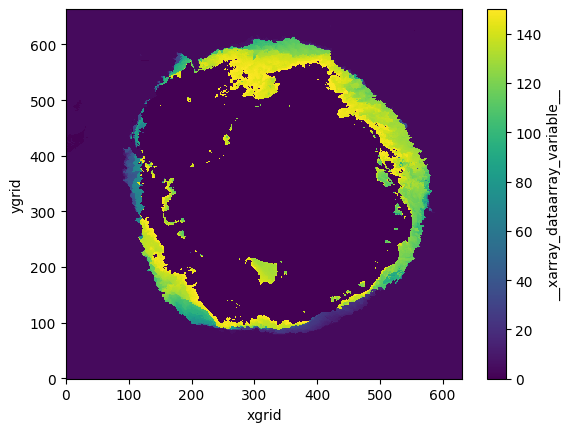

In [1]:
import numpy as np
import glob

import xarray as xr
import seaborn as sns;
import netCDF4 as nc
import os
from netCDF4 import Dataset



## Because the desired output is one slice/ image/grid for each year, I will process year by year
def continuous_meet(cond, window_size, dim):
    """
    Continuously meet a given condition along a dimension.
    """
    _found = cond.rolling(dim={'time': window_size},
                          center=True).sum(skipna=True).fillna(False).astype(np.float)

    detected = np.array(
        _found.rolling(dim={'time': window_size})
        .reduce(lambda a, axis: (a == window_size).any(axis=axis))
        .fillna(False)
        .astype(bool)
    )

    indices = (detected * np.arange(detected.shape[0]).reshape(detected.shape[0], 1, 1))
    indices[indices == 0] = detected.shape[0]
    output = indices.argmin(axis=0)

    return xr.DataArray(output)

sub_data = xr.open_dataset('y12_break5d_30.nc')
print(sub_data)
ice =  sub_data.__xarray_dataarray_variable__
ice.plot()

In [12]:
### Opening large file, which contains a percentage at each cellfrom 0-100, 0 is open ocean, 120 is land

data = xr.open_dataset('daily_sic_subset.nc',engine ="netcdf4") # opening sea ice concentration file 

In [13]:
# ## Arange months up to Aug to December ##
def is_months(month):
    return (month >= 8) & (month <= 12)
data = data.sel(time=is_months(data['time.month']))

In [7]:
# ## Select SIC variable ##
sic_xr = data.SI_12km_SH_ICECON_DAY_SpPolarGrid12km
latitude = data.GridLat_SpPolarGrid12km
longitude = data.GridLon_SpPolarGrid12km

In [8]:
# ## Here we want all the values that are over 100 (missing or land mask) to be set to nan ##
sic_xr = sic_xr.where(sic_xr < 101,np.nan)

In [9]:
## Function to return when a cell has reached a certain percentage (cond) for a continous set amount of days
## (window_size), over a dimension "dim='time'"

def continuous_meet(cond, window_size, dim):
    """
    Continuously meet a given condition along a dimension.
    """
    _found = cond.rolling(dim={'time': window_size},
                          center=True).sum(skipna=True).fillna(False).astype(np.float)

    detected = np.array(
        _found.rolling(dim={'time': window_size})
        .reduce(lambda a, axis: (a == window_size).any(axis=axis))
        .fillna(False)
        .astype(bool)
    )

    indices = (detected * np.arange(detected.shape[0]).reshape(detected.shape[0], 1, 1))
    indices[indices == 0] = detected.shape[0]
    output = indices.argmin(axis=0) #argmin is used to return the 1 first day (index), the condition was met over the 5 days
    

    return xr.DataArray(output)


In [10]:
## Load a output for the year 2012 
sub_data = xr.open_dataset('y12_break5d_30.nc')
print(sub_data)
ice =  sub_data.__xarray_dataarray_variable__


<xarray.Dataset>
Dimensions:                        (ygrid: 664, xgrid: 632)
Coordinates:
    longitude                      (ygrid, xgrid) float64 ...
    latitude                       (ygrid, xgrid) float64 ...
Dimensions without coordinates: ygrid, xgrid
Data variables:
    __xarray_dataarray_variable__  (ygrid, xgrid) int64 ...


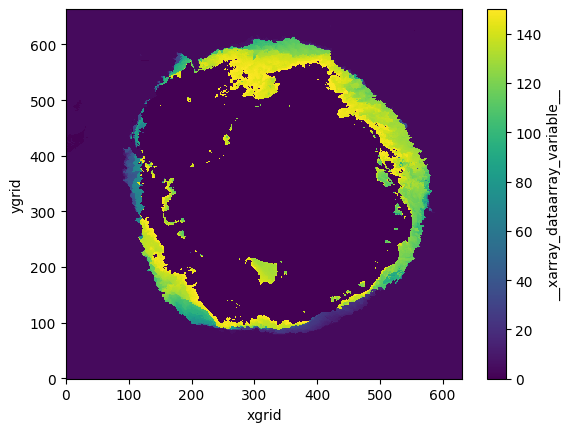

In [11]:
## When looking at the plot, we see the ocean, the continent, and regions that remain ice filled = >30
## are purple. To mask out the continent and ice we can turn 0 into NAN. This makes sense since it never meets
## the condition, i.e it is always over 30, therefore false=0

## When turning 4 into NAN, we mask out the entire ocean. Now it makes sense that it would be the first to go 
## since the ocean is zero consecutively, does that mean that 4 is our first instance ? Why not zero ? Because
## that serves as our flag? Also why not 5, if that is the window size? 

ice.plot()